In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Quantile Analysis
Another form of non-linear analysis is the analysis of the simulated **performance of stocks grouped** based on the information signal.

Alpha models based on factors (value, momentum, profitability, low-risk) normally have a **relative bet structure**: based on the signal we divide stocks into groups (good vs bad, or good vs meh vs bad, or very good vs good vs meh vs...). We are not forecasting that stock ABC will go up, but that will perform better than stock XYZ. 

A natural way to test the quality of an information signal is simply to:
1. **Rank** stocks based on the signal.
1. **Divide** them into groups.
1. **Measure** the future return of said groups.

___
## 1. Data
Let's start by loading our data on returns and an information signal.

In [2]:
# we load the returns and produce the future monthly returns
returns = pd.read_csv('Returns.zip', parse_dates=['date']).set_index(['id', 'date'])
future_returns = returns.groupby('id')['return'].shift(-1).rename('fut_ret')

# we load the information signal. To make our code more general we are going to rename the information signal
signal = pd.read_csv('EPQ.zip', parse_dates=['date']).set_index(['id', 'date'])

# we merge signal and future returns in the same DataFrame
data = signal.join(future_returns).dropna()
data.head()

epq   fut_ret
id    date                          
10001 1986-11-28 -0.346658  0.014889
      1986-12-31 -0.246254 -0.036368
      1987-01-30 -0.326536 -0.076961
      1987-02-27  0.418686  0.036139
      1987-03-31  0.410622 -0.040005

___
## 2. Forming the Groups
We can now start our quantile analysis by grouping the stocks based on the information signal. To achieve this we can use the pandas function [**`pandas.qcut()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html).

In [3]:
# We start by choosing the number of bins
N = 4

# We apply the pandas.qcut() function using a lambda function
data['group'] = data.groupby('date')['epq'].apply(lambda x: pd.qcut(x,N, labels=False))

data.head()

epq   fut_ret  group
id    date                                 
10001 1986-11-28 -0.346658  0.014889      0
      1986-12-31 -0.246254 -0.036368      0
      1987-01-30 -0.326536 -0.076961      0
      1987-02-27  0.418686  0.036139      3
      1987-03-31  0.410622 -0.040005      3

___
### 2.1 An intermission on Lambda Functions
This is the first time we encounter a [**lambda function**](https://realpython.com/python-lambda/). This is a construct common to a number of programming languages. It is technically known as an **anonymous function**. The idea is that you build and run a function in the same line. For example if we want to create a function to add 1 to a number we can write:

In [4]:
def add_one(x):
    return x + 1

#let's test
add_one(2)

3

The following lambda function performs the same task:

In [5]:
lambda x: x + 1

#we can apply the function surrounding the function and its argument in parenthesis
(lambda x: x + 1)(2)

3

A way to understand lambda functions is to read them aloud in this way: the function
```python
lambda x: x + 1
```
becomes "When I give you `x` you give me back `x+1`". 
___
In our code above the function looks like 
```python
lambda x: pd.qcut(x,N, labels=False)
```
and we can read "When I give you `x` give me the group (quantile) to which it belongs after cutting the sample in `N` groups. But what is `x`? Well we use the [**`DataFrame.apply()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method to "apply" this function to our signal after grouping the sample by date. 

Has the function worked? Let's count how many observations we have in any bin. We can easily do this with the method [**`Series.value_counts()`**](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) that simply counts the values of a variable. If we look at the values of the new coulmn we see...

In [6]:
data['group'].value_counts().sort_index() #The sort index is to have the value ranked based on the bin number, the index.

0    514840
1    510269
2    512223
3    512038
Name: group, dtype: int64

...that, in fact, the sample is more or less **equally split between the different groups**. If you are ocd like me and hate to see the group numbering starting from zero, you can apply **add 1 at the end**.

In [7]:
data['group'] = data.groupby('date')['epq'].apply(lambda x: pd.qcut(x,N, labels=False))+1
data['group'].value_counts().sort_index()

1    514840
2    510269
3    512223
4    512038
Name: group, dtype: int64

We can now calculate the average signal, and the **average future return** for the stocks in each group:

In [8]:
portfolios = data.groupby(['date','group']).mean()
portfolios.head(10)

epq   fut_ret
date       group                    
1980-01-31 1     -1.031313 -0.022276
           2     -0.109783 -0.029643
           3      0.231804 -0.042486
           4      0.943896 -0.034873
1980-02-29 1     -1.057291 -0.223656
           2     -0.112860 -0.163428
           3      0.225932 -0.154802
           4      0.937386 -0.152080
1980-03-31 1     -0.956143  0.036317
           2     -0.089798  0.055503

Since we have grouped by 2 variables (`date` and `group`) the output is a DateFrame with a double index: each individual observation is identified by a combination of a specific date and a specific group. This is called a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) and it's a very powerful tool in Pandas. A tool that we have avoided up to this point because it is quite complicated. So, for now, let's keep avoiding it. We can [**`DataFrame.unstack()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html) the groups to have the return of each group in a different column:

In [9]:
port_returns = portfolios['fut_ret'].unstack(level=1) #level 0 is the first index (date), level 1 is the second (group).
port_returns.head()

group,1,2,3,4
date,,,,
1980-01-31,-0.022276,-0.029643,-0.042486,-0.034873
1980-02-29,-0.223656,-0.163428,-0.154802,-0.152080
1980-03-31,0.036317,0.055503,0.057437,0.055318
1980-04-30,0.061919,0.064600,0.075952,0.077991
1980-05-30,0.028787,0.031867,0.028916,0.047009


___
## 3. Measuring the Performance
Now we have easy to use time series for the monthly return of each portfolio. At this point we can start measuring their performance:

In [10]:
# annualized mean return
port_returns.mean()*12

group
1   -0.215281
2   -0.024975
3    0.072524
4    0.120883
dtype: float64

In [11]:
# annualized volatility
port_returns.std()*np.sqrt(12)

group
1    0.290740
2    0.209381
3    0.168941
4    0.189058
dtype: float64

In [12]:
# annualized Sharpe Ratio assuming a risk free rate of 1%
(port_returns.mean()*12 - 0.01) / port_returns.std()*np.sqrt(12)

group
1   -9.298258
2   -2.004467
3    4.441129
4    7.038019
dtype: float64

We can see that the information signal performs well: **higher groups have higher average return**. Instead of printing these performance measures on screen, we can **store them in a DataFrame.**

In [13]:
mean_return = port_returns.mean()*12
volatility = port_returns.std()*np.sqrt(12)
sharpe = (port_returns.mean()*12 - 0.01) / port_returns.std()*np.sqrt(12)

performance = pd.DataFrame({'Mean Ret': mean_return,
                            'Std Dev': volatility,
                            'Sharpe Ratio': sharpe})
performance

,Mean Ret,Std Dev,Sharpe Ratio
group,,,
1,-0.215281,0.290740,-9.298258
2,-0.024975,0.209381,-2.004467
3,0.072524,0.168941,4.441129
4,0.120883,0.189058,7.038019


### 3.1 Plotting Performance
We can also plot the performance of each portfolio. To do this, we need to convert monthly returns into a series of portfolio prices. Since we are using logarithmic returns this is trivial. We know that if an asset has, in three periods, returns equal to $r_{1}$, $r_{2}$ and $r_{3}$, than the return from time 0 to time 3 is simply the sum
$$r_{0, 3} = \sum_{t=1}^{3}r_{t}$$

And we also know that the dollar value at the end of time 3 of a $1 investment in time 0 is

$$W_{3} = \$1\times e^{r_{0, 3}}$$

We can simply apply the Numpy exponential function [**`numpy.exp()`**](https://numpy.org/doc/stable/reference/generated/numpy.exp.html) to the cumulative returns calculated using the [**`DataFrame.cumsum()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) method. 


In [14]:
port_values = port_returns.cumsum().apply(np.exp)
port_values.head()

group,1,2,3,4
date,,,,
1980-01-31,0.977971,0.970792,0.958404,0.965728
1980-02-29,0.781976,0.824424,0.820954,0.829482
1980-03-31,0.810897,0.871476,0.869488,0.876661
1980-04-30,0.862694,0.929632,0.938100,0.947770
1980-05-30,0.887889,0.959733,0.965623,0.993387


And then we can easily **plot them**.

<AxesSubplot:title={'center':'Quantile Portfolio Values'}, xlabel='Time', ylabel='Portfolio Value'>

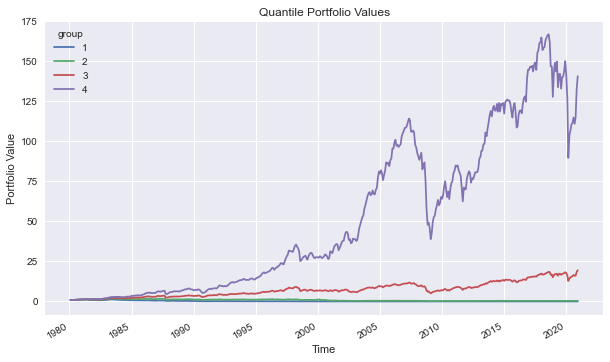

In [15]:
port_values.plot(figsize=(10,6),
                 title='Quantile Portfolio Values',
                 xlabel='Time',
                 ylabel='Portfolio Value')

Visual inspection of the graph confirms that **the information signal has value**: higher signal leads to higher average performance. This is no surprise given the higher average monthly return, but when you present your strategy to possible investors, **a graph is worth 10 tables**...

This graph is not very easy to read. The last quintile portfolio has a very strong performance that, on a linear scale, makes the performance of the other portfolios difficult to read. To be able to compare the returns graphically we need to plot the portfolio values on a **logarithmic scale**.

<AxesSubplot:title={'center':'Quantile Portfolio Values'}, xlabel='Time', ylabel='Portfolio Value (Log-Scale)'>

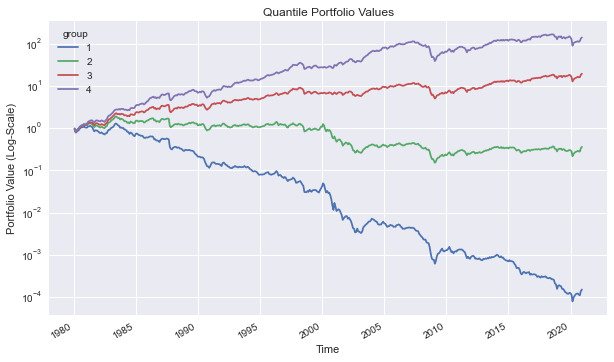

In [16]:
port_values.plot(figsize=(10,6),
                 title='Quantile Portfolio Values',
                 xlabel='Time',
                 ylabel='Portfolio Value (Log-Scale)',
                 logy=True) #the last argument specifies log-scale for the Y axis

Now we clearly see that the ranking of the portfolio performance is as expected: the lower the information signal, the worse is the performance.

___
## 4. Zero-Investment Portfolios
So far we have analyzed the performance of an hypothetical portfolio strategy of the type _"Invest in Group 4"_ or _"Invest in Group N"_. Even if our signal is very good, such a **long-only strategy** could still experience significant losses if the market as a whole falls. The performance of our portfolios **during the GFC** is an example of this.

The reason for this apparent "bug" in our approach, is that our alpha model produces **relative bets**, so we should **invest accordingly**. We do not know that group N will _perform "well"_, we know that it will likely perform _"better than group 1"_, or _"better than the market"_ (the two bets are equivalent: the market is made of group 1, 2, ..., N).

We can simulate the performance of two different **zero-investment strategies**:
* We go long in the "best" group and short on the "worst" group.
* We go long in the "best" group and short on the market.

These strategies are called zero-investment because in an ideal world we could **use the proceeds** from the short positions to finance the investment in the long positions. This is not really the case, as the market regulators normally require **margin deposits** to guarantee the short positions.

Since this is not a realistic backtesting but we are simply doing some non-linear statistical analysis let's start by using the **average return of all the stocks** as a proxy for the market return:

In [17]:
benchmark_return = data.groupby('date')['fut_ret'].mean().rename('Benchmark')
benchmark_return.head()

date
1980-01-31   -0.032314
1980-02-29   -0.173508
1980-03-31    0.051137
1980-04-30    0.070111
1980-05-30    0.034145
Name: Benchmark, dtype: float64

Let's merge this into the `port_returns` DataFrame

In [18]:
port_returns = port_returns.join(benchmark_return.to_frame())
port_returns.head()

,1,2,3,4,Benchmark
date,,,,,
1980-01-31,-0.022276,-0.029643,-0.042486,-0.034873,-0.032314
1980-02-29,-0.223656,-0.163428,-0.154802,-0.152080,-0.173508
1980-03-31,0.036317,0.055503,0.057437,0.055318,0.051137
1980-04-30,0.061919,0.064600,0.075952,0.077991,0.070111
1980-05-30,0.028787,0.031867,0.028916,0.047009,0.034145


Let's now create a zero-investment strategy called `Active` where we go long on the best portfolio and short on the market. In the same way we can create a second zero-investment strategy called `Neutral` where we go long on the best group and short on the worst:

In [19]:
port_returns['Active'] = port_returns[N] - port_returns['Benchmark']
port_returns['Neutral'] = port_returns[N] - port_returns[1]
port_returns.head()

,1,2,3,4,Benchmark,Active,Neutral
date,,,,,,,
1980-01-31,-0.022276,-0.029643,-0.042486,-0.034873,-0.032314,-0.002560,-0.012598
1980-02-29,-0.223656,-0.163428,-0.154802,-0.152080,-0.173508,0.021428,0.071576
1980-03-31,0.036317,0.055503,0.057437,0.055318,0.051137,0.004181,0.019001
1980-04-30,0.061919,0.064600,0.075952,0.077991,0.070111,0.007881,0.016073
1980-05-30,0.028787,0.031867,0.028916,0.047009,0.034145,0.012864,0.018222


In [20]:
mean_return = port_returns.mean()*12
volatility = port_returns.std()*np.sqrt(12)
sharpe = (port_returns.mean()*12 - 0.01) / (port_returns.std()*np.sqrt(12))

performance = pd.DataFrame({'mean_ret': mean_return,
                            'st_dev': volatility,
                            'sharpe_ratio': sharpe})
performance

,mean_ret,st_dev,sharpe_ratio
1,-0.215281,0.290740,-0.774855
2,-0.024975,0.209381,-0.167039
3,0.072524,0.168941,0.370094
4,0.120883,0.189058,0.586502
Benchmark,-0.012009,0.205343,-0.107182
Active,0.132892,0.064319,1.910650
Neutral,0.336164,0.168091,1.940399


We see that both zero-investment strategies yield a good performance. Let's plot them:

In [21]:
port_values = port_returns.cumsum().apply(np.exp)
port_values.head()

,1,2,3,4,Benchmark,Active,Neutral
date,,,,,,,
1980-01-31,0.977971,0.970792,0.958404,0.965728,0.968203,0.997444,0.987481
1980-02-29,0.781976,0.824424,0.820954,0.829482,0.813978,1.019047,1.060752
1980-03-31,0.810897,0.871476,0.869488,0.876661,0.856686,1.023317,1.081100
1980-04-30,0.862694,0.929632,0.938100,0.947770,0.918904,1.031413,1.098617
1980-05-30,0.887889,0.959733,0.965623,0.993387,0.950821,1.044767,1.118819


<AxesSubplot:title={'center':'Zero-Investment Portfolio Value'}, xlabel='Time', ylabel='Portfolio Value (Log-Scale)'>

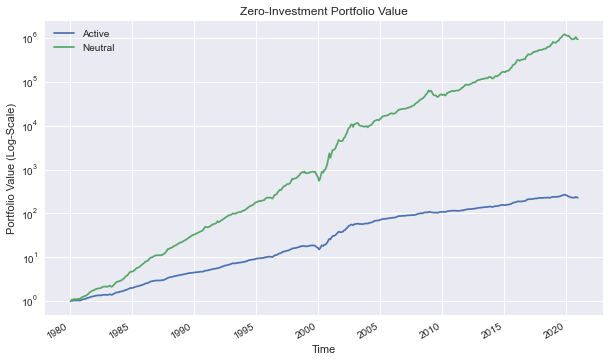

In [22]:
port_values[['Active', 'Neutral']].plot(figsize=(10,6),
                                        title='Zero-Investment Portfolio Value',
                                        xlabel='Time',
                                        ylabel='Portfolio Value (Log-Scale)',
                                        logy=True)

Now we see that our alpha model performs well also during the GFC: **the relative bet still yields a positve performance** in that period.

### 4.1. Period analysis
The fact that our signal has predictive power, on average, between 1980 and 2020 is relevant, but we may be interested to observe the performance in **different periods of time**. 

In [23]:
# we extract the year from the index of the DataFrame
port_returns['year'] = port_returns.index.year
port_returns.head()

,1,2,3,4,Benchmark,Active,Neutral,year
date,,,,,,,,
1980-01-31,-0.022276,-0.029643,-0.042486,-0.034873,-0.032314,-0.002560,-0.012598,1980
1980-02-29,-0.223656,-0.163428,-0.154802,-0.152080,-0.173508,0.021428,0.071576,1980
1980-03-31,0.036317,0.055503,0.057437,0.055318,0.051137,0.004181,0.019001,1980
1980-04-30,0.061919,0.064600,0.075952,0.077991,0.070111,0.007881,0.016073,1980
1980-05-30,0.028787,0.031867,0.028916,0.047009,0.034145,0.012864,0.018222,1980


<AxesSubplot:title={'center':'Neutral Return (Top - Bottom)'}, xlabel='Year', ylabel='Annualized Mean Monthly Return'>

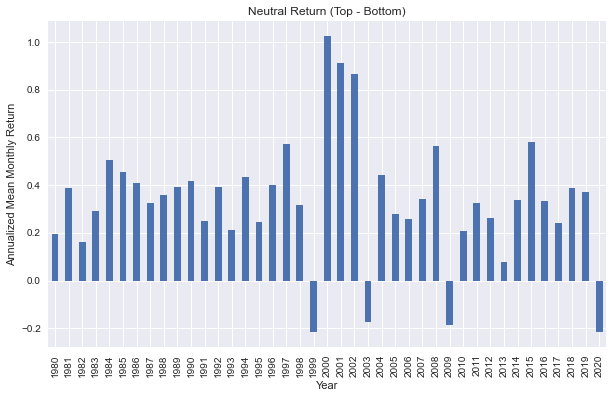

In [24]:
# we can recalculate all our diagnostics by year, for example:
mean_active = port_returns.groupby('year')['Neutral'].mean()*12
mean_active.plot(figsize=(10,6),
                 kind='bar',
                 title='Neutral Return (Top - Bottom)',
                 xlabel='Year',
                 ylabel='Annualized Mean Monthly Return')

And we see that our information signal has predictive power more or less **constantly across our sample**. We also observe that the model **failed during the GFC**. Period analysis can provide many insights, for example we could find out that our signal has not worked well in the last few years...

___
## 5. In Production
As usual, now that we understand the nature of this analysis we want to encapsulate all the relevant code in an easy-to-use function.

In [25]:
def quantile_analysis(signal, returns, n_bins=4):
    
    #We capture the name of the factor using the .name attribute to use it later
    signal_name = signal.name
    
    #We calculate the future returns
    future_returns = returns.groupby('id').shift(-1).rename('fut_ret')
    
    #We join the signal with the future returns
    data = signal.to_frame().join(future_returns).dropna()
    
    #We apply the pandas.qcut() function using a lambda function
    data['group'] = data.groupby('date')[signal_name].apply(lambda x: pd.qcut(x,n_bins, labels=False))+1
    
    #We calculate the average return of the groups
    portfolios = data.groupby(['date','group']).mean()
    
    #We rearrange the results in order to have one group per column
    port_returns = portfolios['fut_ret'].unstack(level=1) 
    
    #We calculate the benchmark return
    benchmark_return = data.groupby('date')['fut_ret'].mean().rename('Benchmark')
    port_returns = port_returns.join(benchmark_return.to_frame())
    
    #We calculate the return of the zero-investment portfolios
    port_returns['Active'] = port_returns[n_bins] - port_returns['Benchmark']
    port_returns['Neutral'] = port_returns[n_bins] - port_returns[1]
    
    return port_returns


#Let's also create a second smaller function with the calculation of the performance measures

def diagnostics(port_returns):
    
    mean_return = port_returns.mean()*12
    volatility = port_returns.std()*np.sqrt(12)
    sharpe = (port_returns.mean()*12 - 0.01) / (port_returns.std()*np.sqrt(12))

    performance = pd.DataFrame({'Mean Ret': mean_return,
                                'Std Dev': volatility,
                                'Sharpe Ratio': sharpe})
    
    return performance

And now, if we want to run the analysis again **using 5 quintiles**, we can do everything with two simple lines of code:

In [26]:
return_5 = quantile_analysis(signal['epq'], returns['return'], n_bins = 5)
performance_5 = diagnostics(return_5)

return_5.head()

,1,2,3,4,5,Benchmark,Active,Neutral
date,,,,,,,,
1980-01-31,-0.020218,-0.028045,-0.033652,-0.047376,-0.032352,-0.032314,-0.000038,-0.012133
1980-02-29,-0.235546,-0.170398,-0.153249,-0.151756,-0.156545,-0.173508,0.016963,0.079002
1980-03-31,0.032646,0.052828,0.061774,0.054677,0.053798,0.051137,0.002660,0.021152
1980-04-30,0.058130,0.068052,0.068318,0.074766,0.081287,0.070111,0.011176,0.023157
1980-05-30,0.028218,0.031071,0.030182,0.033758,0.047477,0.034145,0.013333,0.019259


In [27]:
performance_5

,Mean Ret,Std Dev,Sharpe Ratio
1,-0.238529,0.303645,-0.818487
2,-0.069743,0.230489,-0.345973
3,0.036877,0.179521,0.149713
4,0.086309,0.168168,0.453767
5,0.125853,0.194806,0.594707
Benchmark,-0.012009,0.205343,-0.107182
Active,0.137862,0.064136,1.993594
Neutral,0.364382,0.177886,1.992186


___
### Exercise 8.01
Let's now assess the quality of another commonly used investment strategy: low-volatility. In this case want to invest in low-risk (low beta) stocks. 

**STEP 1:** Load the data in `Betas.zip` into a DataFrame called `new_signal`. Show the first few lines.

In [28]:
new_signal = pd.read_csv('Betas.zip', parse_dates=['date']).set_index(['id', 'date'])
new_signal.head()

beta
id    date                
10001 1996-07-31  0.005470
      1996-08-30  0.007628
      1996-09-30  0.012428
      1996-10-31  0.012139
      1996-11-29  0.015621

Normally we want all our information signals expressed **in the same direction**: conventionally the higher the signal the better the stock. This is not the case with this signal where lower betas are better (the strategy is called _low volatility!_). 

**STEP 2:** To fix this, replace the column `beta` in the DataFrame with minus beta, its negative. In this way the higher the signal the better the stock.

In [29]:
new_signal['beta'] = new_signal['beta']*-1
new_signal.head()

beta
id    date                
10001 1996-07-31 -0.005470
      1996-08-30 -0.007628
      1996-09-30 -0.012428
      1996-10-31 -0.012139
      1996-11-29 -0.015621

**STEP 3:** Use the functions created above to **calculate the performance** (mean return. voaltility, etc.) of **4 quantile portfolios** formed on the historical betas.

In [30]:
return_vol = quantile_analysis(new_signal['beta'], returns['return'], n_bins = 4)
performance_vol = diagnostics(return_vol)
performance_vol

,Mean Ret,Std Dev,Sharpe Ratio
1,-0.022574,0.241934,-0.134640
2,0.033796,0.192516,0.123606
3,0.057392,0.160722,0.294869
4,0.076555,0.116255,0.572488
Benchmark,0.036279,0.173274,0.151659
Active,0.040276,0.075662,0.400152
Neutral,0.099129,0.155908,0.571674


**STEP 4:** Plot the value of the four quantile portfolios together with the benchmark.

<AxesSubplot:title={'center':'Quantile Portfolio Values - Low Vol Strategy'}, xlabel='Time', ylabel='Portfolio Value (Log-Scale)'>

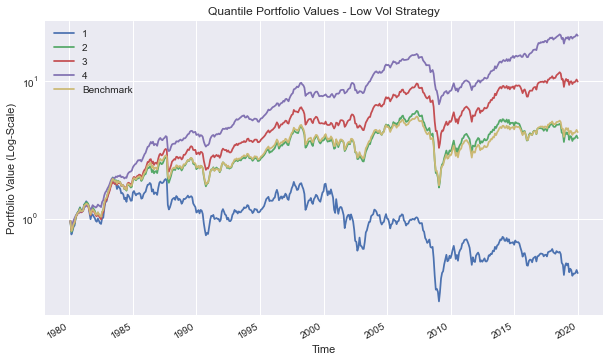

In [31]:
port_vol = return_vol.cumsum().apply(np.exp)

port_vol[[1, 2, 3, 4, 'Benchmark']].plot(figsize=(10,6),
                                         title='Quantile Portfolio Values - Low Vol Strategy',
                                         xlabel='Time',
                                         ylabel='Portfolio Value (Log-Scale)',
                                         logy=True) #the last argument specifies log-scale for the Y axis

**STEP 5:** To visually compare the dynamics of the low-vol strategy compared to the value strategy analyzed in the notebook:
1. Calculate the average annual return of the `Neutral` portfolio of the low-vol strategy
1. Join it in the same DataFrame together with `mean_active` where we have the mean annual return of the value strategy (You may have to change the name of at least one of the series because they have the same name `Neutral`).
1. Plot an Histogram with the two series.

From the diagnostics we know that the low-vol strategy does not perform as well as the value strategy, but **does it help to alleviate the atrocious performance** of value in the dot-com bubble (1999) and the GFC (2008)?

In [32]:
return_vol['year'] = return_vol.index.year
mean_vol = return_vol.groupby('year')['Neutral'].mean()*12

In [33]:
mean_annual = mean_active.rename('Value').to_frame().join(mean_vol.rename('Low Vol'))
mean_annual.head()

,Value,Low Vol
year,,
1980,0.197269,-0.010850
1981,0.387605,0.199785
1982,0.162078,-0.046886
1983,0.292310,0.082746
1984,0.505370,0.195612


<AxesSubplot:title={'center':'Neutral Return (Top - Bottom)'}, xlabel='Year', ylabel='Annualized Mean Monthly Return'>

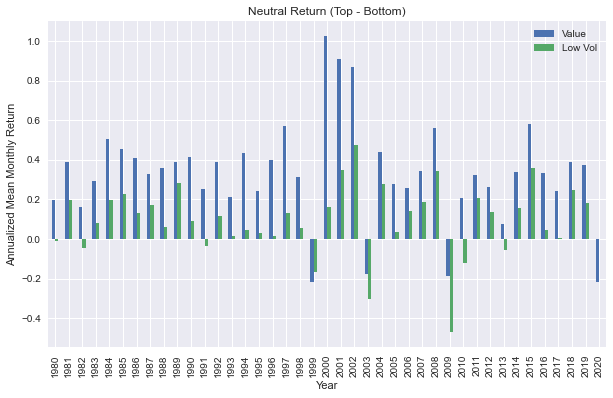

In [34]:
mean_annual.plot(figsize=(10,6),
                 kind='bar',
                 title='Neutral Return (Top - Bottom)',
                 xlabel='Year',
                 ylabel='Annualized Mean Monthly Return')